In [ ]:
#!pip install qiskit

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.optimize import minimize
from qiskit import IBMQ, execute, Aer, QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library.standard_gates import *
%matplotlib inline

In [0]:
nqubit = 3 ## qubitの数
c_depth = 3 ## circuitの深さ
time_step = 0.77  ## ランダムハミルトニアンによる時間発展の経過時間

## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 50

## 学習したい1変数関数
func_to_learn = lambda x: np.sin(x*np.pi)

## 乱数のシード
random_seed = 0
## 乱数発生器の初期化
np.random.seed(random_seed)

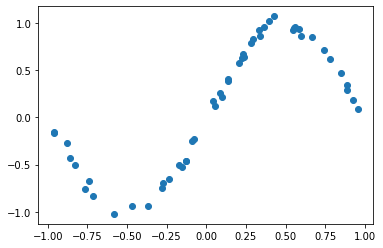

In [0]:
#### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

In [0]:
def U_in(x,circuit):
    for i in range(nqubit):
        circuit.ry(-np.arcsin(x),i)
        circuit.rz(-np.arccos(x**2),i)
    return circuit

[ 9.96242934e-01+0.00000000e+00j -4.99373037e-04+4.99348067e-02j
 -4.99373037e-04+4.99348067e-02j -2.50263813e-03-5.00602719e-05j
 -4.99373037e-04+4.99348067e-02j -2.50263813e-03-5.00602719e-05j
 -2.50263813e-03-5.00602719e-05j  3.76364024e-06-1.25414945e-04j]


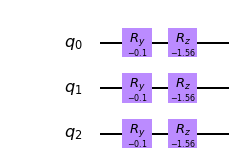

In [0]:
x = 0.1
circuit=QuantumCircuit(nqubit)
circuit=U_in(x,circuit)
backend=Aer.get_backend("statevector_simulator")
print(execute(circuit,backend).result().get_statevector())
circuit.draw("mpl")

In [0]:
I_mat=np.eye(2,dtype=complex)
X_mat=XGate().to_matrix()
Z_mat=ZGate().to_matrix()

def make_fullgate(list_SiteAndOperator, nqubit):
    list_Site= [index[0] for index in list_SiteAndOperator]
    list_SingleGates=[]
    cnt=0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append(list_SiteAndOperator[cnt][1] )
            cnt+=1
        else:
            list_SingleGates.append(I_mat)
    return reduce(np.kron, list_SingleGates)

ham = np.zeros((2**nqubit,2**nqubit),dtype=complex)

for i in range(nqubit):
    Jx = -1.0+2.0*np.random.rand()
    ham+=Jx*make_fullgate([[i,X_mat]],nqubit)
    for j in range(1,nqubit):
        J_ij=-1.0+2.0*np.random.rand()
        ham+= J_ij*make_fullgate( [[i,Z_mat],[j,Z_mat]],nqubit )

In [0]:
diag, eigen_vecs=np.linalg.eigh(ham)
time_evol_op=eigen_vecs@np.diag(np.exp(-1j*time_step*diag))@eigen_vecs.T.conj()
P=Operator(time_evol_op)

In [0]:
def U_out(circuit, theta):
    theta=np.array(theta).reshape(nqubit,c_depth,3)
    for d in range(c_depth):
        circuit.unitary(P,[i for i in range(nqubit)])
        for i in range(nqubit):
            circuit.rx(-theta[i,d,0],i)
            circuit.rz(-theta[i,d,1],i)
            circuit.rx(-theta[i,d,2],i)
    return circuit

In [0]:
obs_matrix=ZGate().to_matrix()
for i in range(nqubit-1):
    obs_matrix=np.kron(np.eye(2),obs_matrix)
obs_matrix=2*obs_matrix

In [0]:
def qcl_pred_(x,theta):
    circuit=QuantumCircuit(nqubit)
    circuit=U_in(x,circuit)
    circuit=U_out(circuit,theta)
    state=execute(circuit,backend).result().get_statevector()
    res=np.dot(state.conj(),np.dot(obs_matrix,state))
    return np.real(res)

def qcl_pred(x,theta):
    circuit=QuantumCircuit(nqubit)

    for i in range(nqubit):
        circuit.ry(-np.arcsin(x),i)
        circuit.rz(-np.arccos(x**2),i)

    theta=np.array(theta).reshape(nqubit,c_depth,3)
    
    for d in range(c_depth):
        circuit.unitary(P,[i for i in range(nqubit)])
        for i in range(nqubit):
            circuit.rx(-theta[i,d,0],i)
            circuit.rz(-theta[i,d,1],i)
            circuit.rx(-theta[i,d,2],i)

    state=execute(circuit,backend).result().get_statevector()
    res=np.dot(state.conj(),np.dot(obs_matrix,state))
    return np.real(res)

In [0]:
def cost_func(theta):
    y_pred=[qcl_pred_(x,theta) for x in x_train]    
    L=((y_pred-y_train)**2).mean()
    return np.real(L)

In [0]:
theta=[2.0*np.pi*np.random.rand() for i in range(3*c_depth*nqubit)]

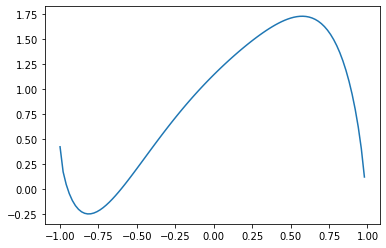

In [0]:
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x,theta) for x in xlist]
plt.plot(xlist, y_init)

In [0]:
result = minimize(cost_func, theta, method='Nelder-Mead')# this might take hours

In [0]:
result.fun
theta_opt=result.x
print(theta_opt)

[4.30322525 0.11859832 1.8539499  2.3119907  2.46811961 4.18575446
 1.701256   1.35189007 1.6666271  5.12129705 4.80830791 3.74609623
 2.08575811 1.59714725 2.37572293 5.82770984 2.04347677 2.99423919
 5.5883891  4.9969435  3.78912903 0.54115376 7.02646341 3.36953774
 5.2312333  1.23908659 7.72088925]


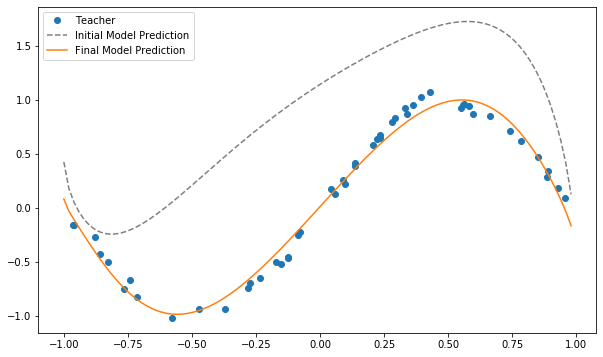

In [0]:
plt.figure(figsize=(10, 6))
xlist = np.arange(x_min, x_max, 0.02)

plt.plot(x_train, y_train, "o", label='Teacher')
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

y_pred = np.array([qcl_pred(x, theta_opt) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()